In [12]:
import numpy as np
import tsdb
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pygrinder import mcar
from pypots.data import load_specific_dataset


In [13]:
### Data preprocesssing
# Load the data 
dataset_name = 'physionet_2012'
data = tsdb.load(dataset_name, use_cache=True)
# Read the keys 
data.keys()
# Show the data structure
for key in data.keys():
    print(f"Key: {key}")
    print(f"Type of {key}: {type(data[key])}")
    if isinstance(data[key], pd.DataFrame) or isinstance(data[key], pd.Series):
        print(data[key].head())  # Print the first few rows if it's a DataFrame or Series
    else:
        print(data[key])
print(data['set-a'].shape)
print(data['set-b'].shape)
print(data['set-c'].shape)
print(data['outcomes-a'].shape)
print(data['outcomes-b'].shape)
print(data['outcomes-c'].shape)
print(data['set-a'].columns)

2024-07-05 11:06:20 [INFO]: You're using dataset physionet_2012, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/physionet_2012
2024-07-05 11:06:20 [INFO]: Dataset physionet_2012 has already been downloaded. Processing directly...
2024-07-05 11:06:20 [INFO]: Dataset physionet_2012 has already been cached. Loading from cache directly...
2024-07-05 11:06:20 [INFO]: Loaded successfully!


Key: set-a
Type of set-a: <class 'pandas.core.frame.DataFrame'>
Parameter  ALP  ALT  AST   Age  Albumin   BUN  Bilirubin  Cholesterol  \
0          NaN  NaN  NaN  35.0      NaN   NaN        NaN          NaN   
1          NaN  NaN  NaN  35.0      NaN   NaN        NaN          NaN   
2          NaN  NaN  NaN  35.0      NaN  68.0        NaN          NaN   
3          NaN  NaN  NaN  35.0      NaN   NaN        NaN          NaN   
4          NaN  NaN  NaN  35.0      NaN   NaN        NaN          NaN   

Parameter  Creatinine  DiasABP  ...  SaO2  SysABP  Temp  Time  TroponinI  \
0                 NaN      NaN  ...   NaN     NaN   NaN     0        NaN   
1                 NaN      NaN  ...   NaN     NaN  36.6     1        NaN   
2                 2.3      NaN  ...   NaN     NaN   NaN     2        NaN   
3                 NaN      NaN  ...   NaN     NaN   NaN     3        NaN   
4                 NaN      NaN  ...   NaN     NaN   NaN     4        NaN   

Parameter  TroponinT  Urine   WBC  Weigh

In [14]:
### Data preprossing
# Remove the static features
data.pop('static_features')
# Remove the corresponding columns for static features
static_features_to_remove = ['Age', 'Gender', 'Height']
static_features_not_to_remove = 'ICUType'
for key in data:
    data[key] = data[key].drop(columns=static_features_to_remove, errors='ignore')
# Concate the cleaned data
keys = ['set-a','set-b','set-c']
concatenated_df = pd.concat([data[key] for key in keys])

def apply_func(df_temp):  # pad and truncate to set the max length of samples as 48
        missing = list(set(range(0, 48)).difference(set(df_temp["Time"])))
        missing_part = pd.DataFrame({"Time": missing})
        df_temp = pd.concat(
            [df_temp, missing_part], ignore_index=False, sort=False
        )  # pad the sample's length to 48 if it doesn't have enough time steps
        df_temp = df_temp.set_index("Time").sort_index().reset_index()
        df_temp = df_temp.iloc[:48]  # truncate
        return df_temp

#X = data['set-a'].groupby("RecordID").apply(apply_func)
X = concatenated_df.groupby("RecordID").apply(apply_func)

In [15]:
X = X.drop("RecordID", axis=1)
X = X.reset_index()
ICUType = X[["RecordID", "ICUType"]].set_index("RecordID").dropna()
X = X.drop(["level_1", "ICUType"], axis=1)

In [16]:
num_samples = len(X['RecordID'].unique())
X = X.drop(['RecordID', 'Time'], axis = 1)
X = StandardScaler().fit_transform(X.to_numpy())
X = X.reshape(num_samples, 48, -1)
X_ori = X  # keep X_ori for validation
X = mcar(X, 0.1)  # randomly hold out 10% observed values as ground truth
dataset = {"X": X}  # X for model input
print(X.shape)  # (11988, 48, 37), All data has 11988 samples and each sample has 48 time steps, 37 features, training set-a for testing purporse

(11988, 48, 37)


In [17]:
from pypots.imputation import SAITS
from pypots.utils.metrics import calc_mae
saits = SAITS(n_steps=48, n_features=37, n_layers=2, d_model=256, d_ffn=128, n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=30)
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
saits.fit(dataset)  # train the model on the dataset
imputation = saits.impute(dataset)  # impute the originally-missing values and artificially-missing values
indicating_mask = np.isnan(X) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation
mae = calc_mae(imputation, np.nan_to_num(X_ori), indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)
saits.save("save_it_here/saits_physionet2012.pypots")  # save the model for future use
saits.load("save_it_here/saits_physionet2012.pypots")  # reload the serialized model file for following imputation or trainin

2024-07-05 11:08:13 [INFO]: No given device, using default device: cpu
2024-07-05 11:08:13 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2024-07-05 11:08:13 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,378,358
2024-07-05 11:10:10 [INFO]: Epoch 001 - training loss: 0.6924
2024-07-05 11:12:15 [INFO]: Epoch 002 - training loss: 0.5115
2024-07-05 11:15:31 [INFO]: Epoch 003 - training loss: 0.4577
2024-07-05 11:17:26 [INFO]: Epoch 004 - training loss: 0.4229
2024-07-05 11:19:19 [INFO]: Epoch 005 - training loss: 0.4005
2024-07-05 11:21:12 [INFO]: Epoch 006 - training loss: 0.3861
2024-07-05 11:22:59 [INFO]: Epoch 007 - training loss: 0.3759
2024-07-05 11:25:00 [INFO]: Epoch 008 - training loss: 0.3666
2024-07-05 11:27:00 [INFO]: Epoch 009 - training loss: 0.3620
2024-07-05 11:28:52 [INFO]: Epoch 010 - training loss: 0.3555
2024-07-05 11:28:52 [INFO]: Finished training. The best model is from epoch#

In [18]:
saits.save("save_it_here/saits_physionet2012_whole_data.pypots")  # save the model for future use
saits.load("save_it_here/saits_physionet2012_whole_data.pypots")  # reload the serialized model file for following imputation or trainin

2024-07-05 11:30:05 [INFO]: Saved the model to save_it_here/saits_physionet2012_whole_data.pypots
2024-07-05 11:30:05 [INFO]: Model loaded successfully from save_it_here/saits_physionet2012_whole_data.pypots


/var/folders/b1/7lfcv4zd3hq_zvqkd6yfpwxw0000gn/T/ipykernel_1401/511372326.py:6: RuntimeWarning: divide by zero encountered in divide
  difference = np.abs((imputation - X_ori) / X_ori)*100
/var/folders/b1/7lfcv4zd3hq_zvqkd6yfpwxw0000gn/T/ipykernel_1401/511372326.py:6: RuntimeWarning: invalid value encountered in divide
  difference = np.abs((imputation - X_ori) / X_ori)*100


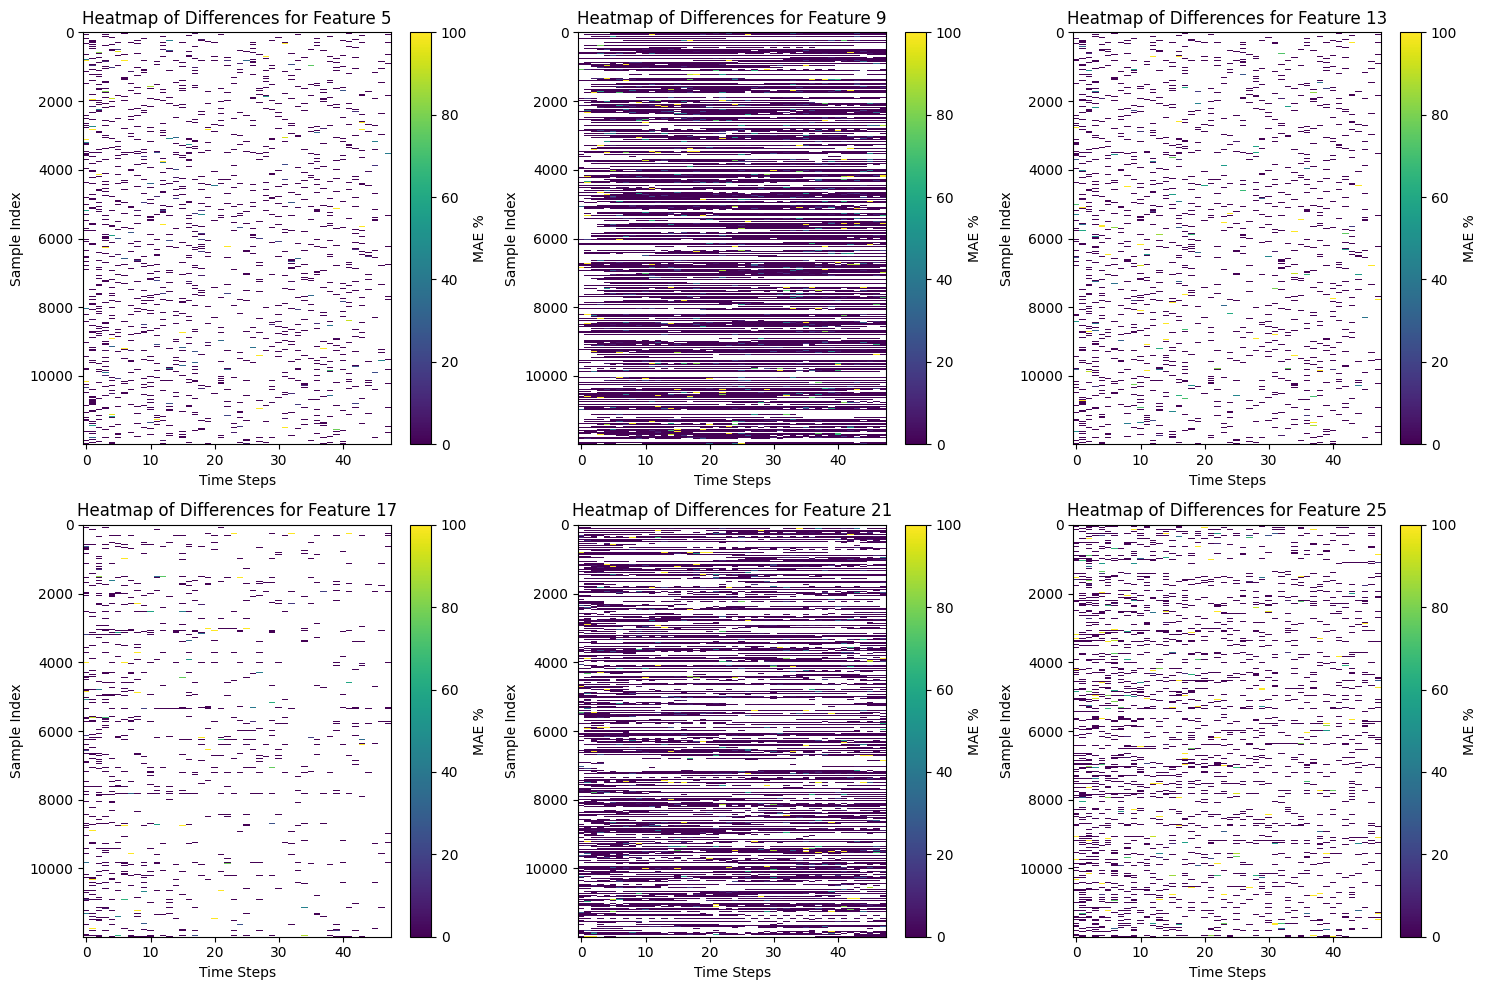

In [19]:
import matplotlib.pyplot as plt
# Ensure the matrices are of the same shape for element-wise operations
assert X_ori.shape == imputation.shape, "Matrices must have the same shape for element-wise operations."

# Calculate the difference matrix
difference = np.abs((imputation - X_ori) / X_ori)*100

# Define the number of features you want to visualize
features_to_visualize = [4,8,12,16,20,24]  # You can adjust this list as needed
num_features = len(features_to_visualize)

# Define the grid layout for subplots
rows, cols = 2, 3  # Adjust the number of rows and columns as needed

# Create a figure with a grid of subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 10))

for idx, feature_index in enumerate(features_to_visualize):
    row, col = divmod(idx, cols)
    ax = axs[row, col]
    #difference[:, :, feature_index]
    # Create a heatmap for each feature
    cax = ax.imshow(difference[:, :, feature_index], aspect='auto', cmap='viridis', interpolation='nearest', vmin=0, vmax=100)
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Sample Index')
    ax.set_title(f'Heatmap of Differences for Feature {feature_index + 1}')
    
    # Add a color bar to each subplot
    cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
    cbar.set_label('MAE %')
    

# If the number of features is less than the number of subplots, hide the remaining subplots
for idx in range(num_features, rows * cols):
    row, col = divmod(idx, cols)
    fig.delaxes(axs[row, col])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()